In [1]:
import functools
import numpy as np
from beam.system import System
from beam import mesh
from beam import postprocessing as postproc
import matplotlib.pyplot as plt

In [2]:
def case_touching(nele, nint):
    """
    In this example, one cantilever beam is bent towards another.
    Beams are initially touching.
    Contact, static analysis.
    """
    
    mat = {
        'EA':np.pi*1.0e5,
        'GA1':1.2083e5,
        'GA2':1.2083e5,
        'GIt':6.04158,
        'EI1':7.85398,
        'EI2':7.85398,
        'Arho':1.0,
        'I12rho':1.0,
        'I1rho':1.0,
        'I2rho':1.0,
        'Contact radius':0.01
    }
    
    (coordinates1, elements1) = mesh.line_mesh(A=(0,0,0.01), B=(5,0,0.01), n_elements=nele, order=2, material=mat, reference_vector=(0,0,1))
    (coordinates2, elements2) = mesh.line_mesh(A=(0,0,-0.01), B=(5,0,-0.01), n_elements=nele, order=2, material=mat, reference_vector=(0,0,1),
                                               starting_node_index=coordinates1.shape[1])
   
    neighbouring_elements = 1
    for (i2, ele) in enumerate(elements2):
        if i2 == 0:
            pce = elements1[:neighbouring_elements+1]
        else:
            pce = elements1[i2-neighbouring_elements:i2+neighbouring_elements]
        mesh.add_mortar_element([ele], possible_contact_partners=pce, n_contact_integration_points=nint)

    coordinates = np.hstack((coordinates1, coordinates2))
    elements = elements1 + elements2
    system = System(coordinates, elements)
    system.time_step = 1.0
    system.max_number_of_time_steps = 1000
    system.max_number_of_contact_iterations = 50
    system.final_time = 9.0
    system.solver_type = 'static'
    system.tolerance = 1e-6
    system.convergence_test_type = 'RES'
    system.contact_detection = True
    system.print_residual = True
    
    def user_displacement_load(self):
        n_nodes = self.get_number_of_nodes()
        Q = np.zeros((6, n_nodes))
        radius = self.coordinates[2,0]
        freq = 2*np.pi/8
        if self.current_time > 1:
            t = self.current_time-1
            Q[1,coordinates1.shape[1]-1] = 0.01*(np.sin(freq*t) - np.sin(freq*(t - self.time_step)))
            Q[2,coordinates1.shape[1]-1] = 0.01*(np.cos(freq*t) - np.cos(freq*(t - self.time_step)))
            Q[1,-1] = -0.01*(np.sin(freq*t) - np.sin(freq*(t - self.time_step)))
            Q[2,-1] = -0.01*(np.cos(freq*t) - np.cos(freq*(t - self.time_step)))
        else:
            Q[0,coordinates1.shape[1]-1] = 0.04967
            Q[0,-1] = 0.04967
        return Q

    
    system.degrees_of_freedom[-1][:6,0] = False  # [current time, dof 0 through 5, first node of the first beam]
    system.degrees_of_freedom[-1][:6,coordinates1.shape[1]] = False  # [current time, dof 0 through 5, first node of the second beam]
    system.degrees_of_freedom[-1][:6, coordinates1.shape[1]-1] = False  # [current time, dof 0 through 5, last node of the first beam]
    system.degrees_of_freedom[-1][:6,-1] = False  # [current time, dof 0 through 5, last node of the second beam]
    system.displacement_load = functools.partial(user_displacement_load, system)
    
    return system

In [3]:
system11 = case_touching(8, 8)
system11.solve()
system12 = case_touching(16, 8)
system12.solve()
system13 = case_touching(32, 8)
system13.solve()
system14 = case_touching(64, 8)
system14.solve()

n: 1 	Residual: 121.09246223391337
Iteration: 2 	Residual: 123.57730680214877
Iteration: 3 	Residual: 0.7975037207837473
Iteration: 4 	Residual: 0.001770113321861903
Iteration: 5 	Residual: 7.472491074145694e-09
	Time step converged within 6 iterations.

Time step: 4 (time 3.0 --> 4.0)
Iteration: 0 	Residual: 5692.948443456635
Iteration: 1 	Residual: 138.31501977811962
Iteration: 2 	Residual: 132.69328172507875
Iteration: 3 	Residual: 0.8390843064087683
Iteration: 4 	Residual: 0.002308162395710113
Iteration: 5 	Residual: 4.810772323173408e-09
	Time step converged within 6 iterations.

Time step: 5 (time 4.0 --> 5.0)
Iteration: 0 	Residual: 5693.229286078057
Iteration: 1 	Residual: 157.57702348464596
Iteration: 2 	Residual: 142.90682546919354
Iteration: 3 	Residual: 0.8500861954352154
Iteration: 4 	Residual: 0.002915091492845702
Iteration: 5 	Residual: 5.7227563435123044e-09
	Time step converged within 6 iterations.

Time step: 6 (time 5.0 --> 6.0)
Iteration: 0 	Residual: 5693.625737452

Text(0, 0.5, '$\\lambda$')

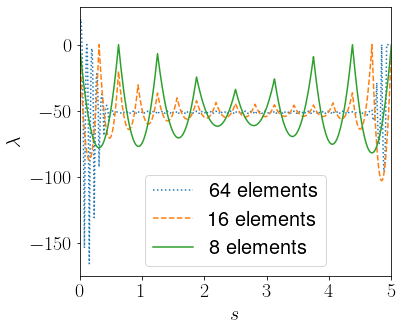

In [4]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"],
    "font.size": 20
})
fig = plt.figure(figsize=(6,5), tight_layout=True)
ax = plt.axes()
ax.plot(*system14.contact_force_function(-1, int_only=False).T, ':', label='64 elements')
ax.plot(*system12.contact_force_function(-1, int_only=False).T, '--', label='16 elements')
ax.plot(*system11.contact_force_function(-1, int_only=False).T, label='8 elements')
plt.legend()
ax.set_xlim((0,5))
ax.set_xlabel('$s$')
ax.set_ylabel('$\lambda$')
#plt.savefig("img2.pdf", bbox_inches='tight')

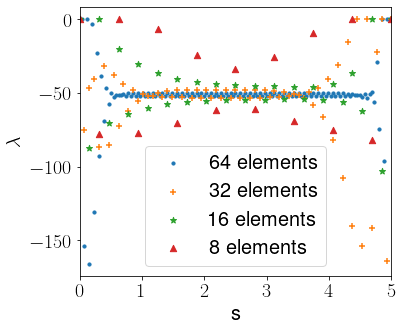

In [5]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"],
    "font.size": 20
})
fig = plt.figure(figsize=(6,5), tight_layout=True)
ax = plt.axes()
f1 = system11.lagrange[-1][len(system11.lagrange[-1])//2:]
f2 = system12.lagrange[-1][len(system12.lagrange[-1])//2:]
f3 = system13.lagrange[-1][len(system13.lagrange[-1])//2:]
f4 = system14.lagrange[-1][len(system14.lagrange[-1])//2:]
x1 = np.linspace(0, 5, len(f1))
x2 = np.linspace(0, 5, len(f2))
x3 = np.linspace(0, 5, len(f3))
x4 = np.linspace(0, 5, len(f4))
ax.scatter(x4, f4, marker=".", s=40, label='64 elements')
ax.scatter(x3, f3, marker="+", s=40, label='32 elements')
ax.scatter(x2, f2, marker="*", s=40, label='16 elements')
ax.scatter(x1, f1, marker="^", s=40, label='8 elements')
ax.set_xlim((0,5))
ax.set_xlabel('s')
ax.set_ylabel('$\lambda$')
plt.legend()
#plt.savefig("img2.pdf", bbox_inches='tight')

In [8]:
system16 = case_touching(8, 3)
system16.solve()
system17 = case_touching(8, 2)
system17.solve()

Hello, world!
This is a FEM program for beam analysis.
This will be a static analysis.
Time step: 1 (time 0.0 --> 1.0)
Iteration: 0 	Residual: 94888.68690175211
Iteration: 1 	Residual: 6.021637360337939e-09
	Time step converged within 2 iterations.

	Active nodes have changed: repeat time step.

Iteration: 0 	Residual: 6.021637360337939e-09
	Time step converged within 1 iterations.

Time step: 2 (time 1.0 --> 2.0)
Iteration: 0 	Residual: 5692.731561772526
Iteration: 1 	Residual: 123.54347253808572
Iteration: 2 	Residual: 153.72559108651618
Iteration: 3 	Residual: 0.7471082184519685
Iteration: 4 	Residual: 0.0010922180191656396
Iteration: 5 	Residual: 5.19681143012179e-09
	Time step converged within 6 iterations.

	Active nodes have changed: repeat time step.

Iteration: 0 	Residual: 0.8113332602294838
Iteration: 1 	Residual: 0.06980299570922564
Iteration: 2 	Residual: 3.1690328174219698e-06
Iteration: 3 	Residual: 5.1742268453237545e-09
	Time step converged within 4 iterations.

	Activ

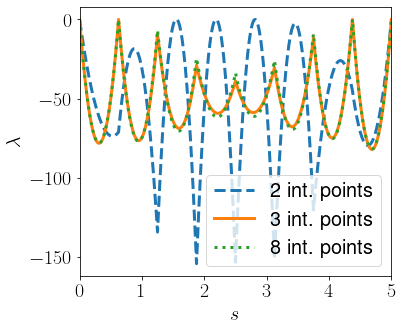

In [16]:
fig = plt.figure(figsize=(6,5), tight_layout=True)
ax = plt.axes()
f1 = system11.contact_force_function(-1)
f6 = system16.contact_force_function(-1)
f7 = system17.contact_force_function(-1)
ax.plot(f7[:,0], f7[:,1], '--', label='2 int. points', linewidth=3.0)
ax.plot(f6[:,0], f6[:,1], '-', label='3 int. points', linewidth=3.0)
ax.plot(f1[:,0], f1[:,1], ':', label='8 int. points', linewidth=3.0)
ax.set_xlim((0,5))
ax.set_xlabel('$s$')
ax.set_ylabel('$\lambda$')
plt.legend()
plt.savefig("int.pdf", bbox_inches='tight')